- last week we learnt the rolling model
- this week we would learn ensemble methods and intraday trading

In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [2]:
import warnings
 
warnings.filterwarnings('ignore')

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [4]:
product_list = ["bu", "ru", "v", "pp", "l", "jd"]

In [5]:
period = 4096

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1119


1119

In [7]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [8]:
train_sample = all_dates<"201910"
test_sample = all_dates>"201910"
new_date = "20220225"
out_sample = all_dates>=new_date
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
sum(out_sample)

53

In [9]:
import dask
from dask import compute, delayed

In [10]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [11]:
SAVE_PATH = "e:/intern"

In [13]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        if hasattr(x, "__len__"):
            res = np.zeros(len(x))
        else:
            res = 0
        
    return res

class foctor_total_trade_imb_period(factor_template):
    factor_name = "total.trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(zero_divide(ewma(data["buy.trade"]+data["buy2.trade"]-data["sell.trade"]-data["sell2.trade"], period, adjust=True), 
                           ewma(data["qty"], period, adjust=True)),1).values

class foctor_trade_imb_period(factor_template):
    factor_name = "trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"]), period, adjust=True).values


from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period).values
    
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values
    
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True).values

class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True), round(period/5), adjust=True).values

from collections import OrderedDict
class foctor_std_period(factor_template):
    factor_name = "std.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12 ,13)))
    ])
    
    def formula(self, data, period):
        return np.sqrt(fast_roll_var(data["wpr"], period))


from collections import OrderedDict
class foctor_range_period(factor_template):
    factor_name = "range.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return data["max."+str(period)]-data["min."+str(period)]
    
from collections import OrderedDict
class foctor_volume_open_ratio_period(factor_template):
    factor_name = "volume.open.ratio.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(cum(data["qty"],period), cum(data["cum.open.int"]/period,period))

from collections import OrderedDict
class foctor_trend_index_period(factor_template):
    factor_name = "trend.index.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        aa = zero_divide(abs(data["wpr"]-data["wpr"].shift(period)), data["max."+str(period)]-data["min."+str(period)])
        aa[0:period]=0
        return aa

def get_atr(file, product, period_list, spread, SAVE_PATH="e:/intern"):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/spread
        save(S, SAVE_PATH+"/tmp pkl/"+product+"/atr."+str(period)+"/" + file[-12:])

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

- Now we generate all the signals one by one for the new data

In [14]:
x1 = foctor_trade_imb_period()
x2 = foctor_total_trade_imb_period()
x3 = foctor_nr_period()
x4 = foctor_dbook_period()
x5 = foctor_range_pos_period()
x6 = foctor_price_osci_period()
x7 = foctor_ma_diff_period()
x8 = foctor_kdj_j_period()
x9 = foctor_kdj_k_period()
x10 = foctor_range_period()
x11 = foctor_std_period()
x12 = foctor_volume_open_ratio_period()
x13 = foctor_trend_index_period()

In [15]:
new_dates = all_dates[all_dates>=new_date]
new_dates.sort()
len(new_dates)

53

In [16]:
import os
SAVE_PATH = "e:/intern"
for product in product_list:
    os.makedirs(SAVE_PATH + "/tmp pkl/" + product, exist_ok=True)

In [17]:
all_signal_list = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13]
for product in product_list:
    for xx in all_signal_list:
        create_signal_path(xx, product, SAVE_PATH)

e:/intern/tmp pkl/bu/trade.imb.4096
e:/intern/tmp pkl/bu/total.trade.imb.4096
e:/intern/tmp pkl/bu/nr.4096
e:/intern/tmp pkl/bu/dbook.4096
e:/intern/tmp pkl/bu/range.pos.4096
e:/intern/tmp pkl/bu/price.osci.4096
e:/intern/tmp pkl/bu/ma.dif.10.4096
e:/intern/tmp pkl/bu/kdj.j.4096
e:/intern/tmp pkl/bu/kdj.k.4096
e:/intern/tmp pkl/bu/range.4096
e:/intern/tmp pkl/bu/std.4096
e:/intern/tmp pkl/bu/volume.open.ratio.4096
e:/intern/tmp pkl/bu/trend.index.4096
e:/intern/tmp pkl/ru/trade.imb.4096
e:/intern/tmp pkl/ru/total.trade.imb.4096
e:/intern/tmp pkl/ru/nr.4096
e:/intern/tmp pkl/ru/dbook.4096
e:/intern/tmp pkl/ru/range.pos.4096
e:/intern/tmp pkl/ru/price.osci.4096
e:/intern/tmp pkl/ru/ma.dif.10.4096
e:/intern/tmp pkl/ru/kdj.j.4096
e:/intern/tmp pkl/ru/kdj.k.4096
e:/intern/tmp pkl/ru/range.4096
e:/intern/tmp pkl/ru/std.4096
e:/intern/tmp pkl/ru/volume.open.ratio.4096
e:/intern/tmp pkl/ru/trend.index.4096
e:/intern/tmp pkl/v/trade.imb.4096
e:/intern/tmp pkl/v/total.trade.imb.4096
e:/intern/tm

In [18]:
%%time
i = 0
all_signal_list = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13]
for xx in all_signal_list:
    for product in product_list:
        print("signal ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH)
    i = i + 1

# Wall time: 14min 7s

signal  0 bu
signal  0 ru
signal  0 v
signal  0 pp
signal  0 l
signal  0 jd
signal  1 bu
signal  1 ru
signal  1 v
signal  1 pp
signal  1 l
signal  1 jd
signal  2 bu
signal  2 ru
signal  2 v
signal  2 pp
signal  2 l
signal  2 jd
signal  3 bu
signal  3 ru
signal  3 v
signal  3 pp
signal  3 l
signal  3 jd
signal  4 bu
signal  4 ru
signal  4 v
signal  4 pp
signal  4 l
signal  4 jd
signal  5 bu
signal  5 ru
signal  5 v
signal  5 pp
signal  5 l
signal  5 jd
signal  6 bu
signal  6 ru
signal  6 v
signal  6 pp
signal  6 l
signal  6 jd
signal  7 bu
signal  7 ru
signal  7 v
signal  7 pp
signal  7 l
signal  7 jd
signal  8 bu
signal  8 ru
signal  8 v
signal  8 pp
signal  8 l
signal  8 jd
signal  9 bu
signal  9 ru
signal  9 v
signal  9 pp
signal  9 l
signal  9 jd
signal  10 bu
signal  10 ru
signal  10 v
signal  10 pp
signal  10 l
signal  10 jd
signal  11 bu
signal  11 ru
signal  11 v
signal  11 pp
signal  11 l
signal  11 jd
signal  12 bu
signal  12 ru
signal  12 v
signal  12 pp
signal  12 l
signal  

In [19]:
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["range", "std", "volume.open.ratio", "trend.index"]
period_list = np.power(2, range(12,13))

In [20]:
def construct_composite_signal(dire_signal, range_signal, period_list, date_list, product_list, HEAD_PATH):
    from collections import OrderedDict
    class foctor_xx_period(factor_template):
        factor_name = dire_signal+"."+range_signal+".period"
        params = OrderedDict([
            ("period", period_list)
        ])
        def formula(self, data, period):
            return (data[dire_signal+"."+str(period)]*data[range_signal+"."+str(period)]).values
    xx = foctor_xx_period()
    for product in product_list:
        create_signal_path(xx, product, HEAD_PATH)
        file_list = [DATA_PATH+product+"/"+date for date in date_list]
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=HEAD_PATH)

In [21]:
%%time
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        construct_composite_signal(dire_signal, range_signal, period_list, new_dates, product_list, SAVE_PATH)

## Wall time: 36min 12s

e:/intern/tmp pkl/bu/trade.imb.range.4096
e:/intern/tmp pkl/ru/trade.imb.range.4096
e:/intern/tmp pkl/v/trade.imb.range.4096
e:/intern/tmp pkl/pp/trade.imb.range.4096
e:/intern/tmp pkl/l/trade.imb.range.4096
e:/intern/tmp pkl/jd/trade.imb.range.4096
e:/intern/tmp pkl/bu/total.trade.imb.range.4096
e:/intern/tmp pkl/ru/total.trade.imb.range.4096
e:/intern/tmp pkl/v/total.trade.imb.range.4096
e:/intern/tmp pkl/pp/total.trade.imb.range.4096
e:/intern/tmp pkl/l/total.trade.imb.range.4096
e:/intern/tmp pkl/jd/total.trade.imb.range.4096
e:/intern/tmp pkl/bu/nr.range.4096
e:/intern/tmp pkl/ru/nr.range.4096
e:/intern/tmp pkl/v/nr.range.4096
e:/intern/tmp pkl/pp/nr.range.4096
e:/intern/tmp pkl/l/nr.range.4096
e:/intern/tmp pkl/jd/nr.range.4096
e:/intern/tmp pkl/bu/dbook.range.4096
e:/intern/tmp pkl/ru/dbook.range.4096
e:/intern/tmp pkl/v/dbook.range.4096
e:/intern/tmp pkl/pp/dbook.range.4096
e:/intern/tmp pkl/l/dbook.range.4096
e:/intern/tmp pkl/jd/dbook.range.4096
e:/intern/tmp pkl/bu/range.pos

In [22]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
    #parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=[4096], spread=spread) 
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(12,13)), spread=spread) 

# Wall time: 39.9 s


Wall time: 29.5 s


In [23]:
def count_daily_num(x, period):
    data = load(x)
    return np.floor(sum(data["good"])/period)

In [24]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"/daily num/"+product+".pkl")

# Wall time: 12min 48s



Wall time: 7min 20s


In [25]:
def get_signal_mat(signal_mat, signal_name, product, file_name, HEAD_PATH):
    S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file_name)
    S[np.isnan(S)] = 0
    if signal_mat is None:
        return S
    else:
        return np.vstack((signal_mat, S))


In [26]:
def par_get_signal_mat(file_name, product, signal_list, HEAD_PATH, SAVE_PATH):
    signal_mat = functools.reduce(functools.partial(get_signal_mat, product=product, file_name=file_name, HEAD_PATH=SAVE_PATH), signal_list, None)
    save(signal_mat, SAVE_PATH+"/signal mat pkl/"+product+"/"+file_name)

In [27]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/signal mat pkl/"+product, exist_ok=True)

In [28]:
%%time
for product in product_list:
    print(product)
    parLapply(CORE_NUM, new_dates, par_get_signal_mat, 
              product=product, signal_list=signal_list, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    
# cu
# zn
# ni
# ag
# au
# Wall time: 9min 46s


bu
ru
v
pp
l
jd
Wall time: 2min 1s


- we test several models:
- in-sample/out-sample lasso of week 9
- rolling lasso of week 9
- medium frequency lasso of week 11

In [29]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".004"

In [30]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-4]
signal_names
col_names = ori_mat.columns

In [31]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl").iloc[:-1,:]
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in product_list[1:]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl").iloc[:-1,:]
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

    
# bu (3999, 49)
# ru (4163, 49)
# v (1755, 49)
# pp (2673, 49)
# l (1936, 49)
# jd (1562, 49)




bu (3999, 49)
ru (4163, 49)
v (1755, 49)
pp (2673, 49)
l (1936, 49)
jd (1562, 49)


In [32]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = np.array([signal+".4096" for signal in all_signal_list])
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002", "ret.4096.004"])
n_signal = len(signal_list)

In [33]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [34]:
x_train = train_mat.iloc[:, :n_signal].values
#x_train = train_mat[result["chosen.signals"]]
#x_train = train_mat[signal_list[chosen_signals]]
y_train = train_mat.loc[:, y_signal].values
print(np.shape(x_train))
scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
#fit_coef = np.zeros(n_signal)
#fit_coef[pos] = model.coef_/x_std
fit_coef = model.coef_/x_std
print(fit_coef)

# (16696, 45)
# [ 0.          0.          0.          0.         -0.          0.
#  -0.          0.         -0.          0.          0.          0.
#  -0.01071724 -0.          0.         -0.          0.         -0.
#   0.          0.          0.         -0.         -0.01208749 -0.
#  -0.          0.         -0.          0.          0.          0.
#  -0.          0.          0.          0.          0.00016788  0.
#  -0.          0.00607872  0.         -0.          0.          0.01317737
#   0.          0.00358887  0.        ]


(16088, 45)
[-0.          0.          0.         -0.         -0.          0.00663095
  0.         -0.         -0.         -0.         -0.          0.
 -0.02034936 -0.01748058  0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.
 -0.00174033  0.          0.         -0.          0.          0.00897258
  0.          0.          0.        ]


In [36]:
coef_list=dict([])
for product in product_list:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])

bu
price.osci.4096                0.000070
dbook.range.4096              -0.000082
range.pos.range.4096          -0.000024
trade.imb.trend.index.4096    -0.000419
price.osci.trend.index.4096    0.000145
dtype: float64
ru
price.osci.4096                0.000067
dbook.range.4096              -0.000031
range.pos.range.4096          -0.000006
trade.imb.trend.index.4096    -0.000614
price.osci.trend.index.4096    0.000165
dtype: float64
v
price.osci.4096                0.000077
dbook.range.4096              -0.000034
range.pos.range.4096          -0.000011
trade.imb.trend.index.4096    -0.000298
price.osci.trend.index.4096    0.000162
dtype: float64
pp
price.osci.4096                0.000062
dbook.range.4096              -0.000064
range.pos.range.4096          -0.000008
trade.imb.trend.index.4096    -0.000571
price.osci.trend.index.4096    0.000135
dtype: float64
l
price.osci.4096                0.000061
dbook.range.4096              -0.000034
range.pos.range.4096          -0.000008
trade.i

In [43]:
strat = "overall.energy.lasso."+str(period)
   
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [44]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, new_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    
# bu
# ru
# v
# pp
# l
# jd
# Wall time: 1min 17s



bu
ru
v
pp
l
jd
Wall time: 1min 17s


In [39]:
def get_good(date, product, HEAD_PATH, SAVE_PATH):
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+date)
    good = data["good"]
    save(good, SAVE_PATH+"/good pkl/"+product+"/"+date)  

In [40]:
%%time
for product in product_list:
    parLapply(CORE_NUM, new_dates, get_good, product=product, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern")
    
#Wall time: 28.6 s

Wall time: 28.6 s


In [45]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("overall.energy.lasso", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                    period=4096, split_str="201910", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 10min 48s



reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 10min 48s


bu train sharpe  0.6011867350266192 test sharpe  -0.09541099203794785
v train sharpe  0.7502234166946331 test sharpe  -0.7150660117182565
pp train sharpe  0.5659746919019489 test sharpe  0.7596547613576884
jd train sharpe  0.9873835892951233 test sharpe  1.316018611869797
train sharpe:  1.1864715941142208 test sharpe:  0.3405813572383902


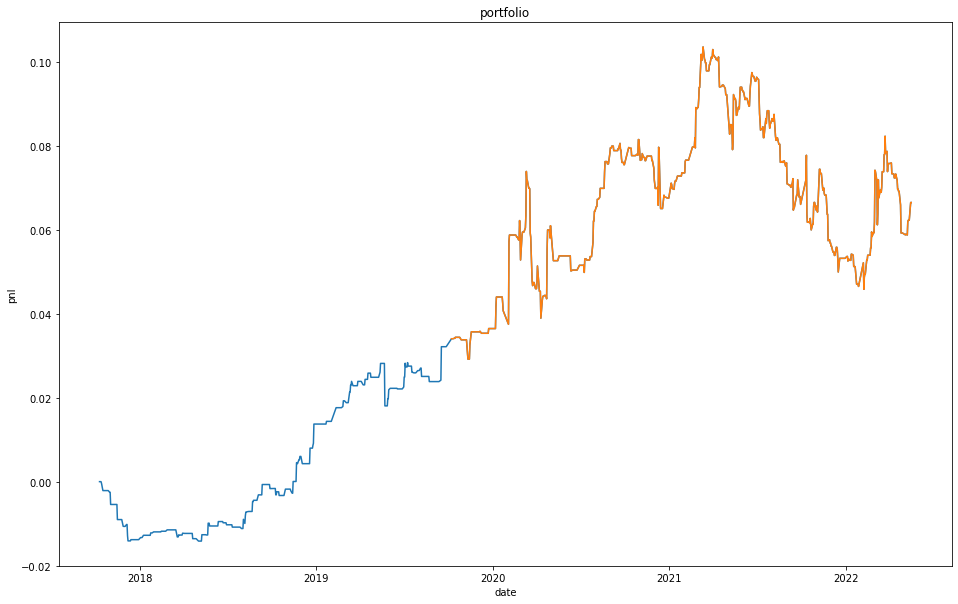

In [46]:
i = 0
strat = "overall.energy.lasso.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if sum(good_strat)==0:
        continue
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
train_test_portfolio = all_portfolio
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))  

# bu train sharpe  0.6011867350266192 test sharpe  -0.09541099203794785
# v train sharpe  0.7502234166946331 test sharpe  -0.7150660117182565
# pp train sharpe  0.5659746919019489 test sharpe  0.7596547613576884
# jd train sharpe  0.9873835892951233 test sharpe  1.316018611869797
# train sharpe:  1.1864715941142208 test sharpe:  0.3405813572383902




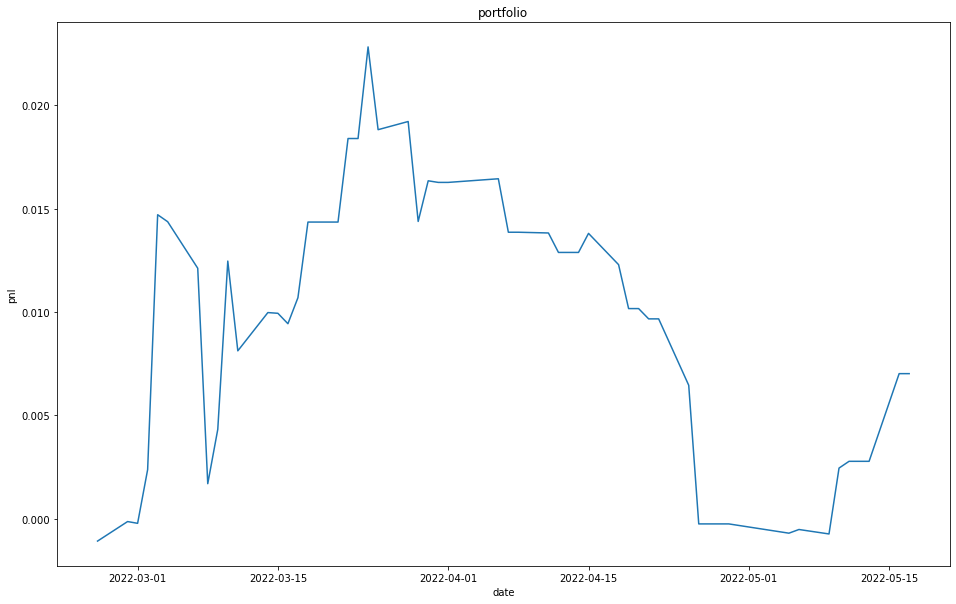

In [48]:
out_sample = all_dates>=new_date
plt.figure(1, figsize=(16, 10));
plt.title("")
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates[out_sample], all_portfolio[out_sample].cumsum())

- we can see that the out-sample portfolio is quite good
- now we go to the rolling lasso model

In [50]:
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr",
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "201910")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [51]:
month = np.array([file[:6] for file in all_dates])
month_len = np.unique(month, return_counts=True)
month_len

# (array(['201710', '201711', '201712', '201801', '201802', '201803',
#         '201804', '201805', '201806', '201807', '201808', '201809',
#         '201810', '201811', '201812', '201901', '201902', '201903',
#         '201904', '201905', '201906', '201907', '201908', '201909',
#         '201910', '201911', '201912', '202001', '202002', '202003',
#         '202004', '202005', '202006', '202007', '202008', '202009',
#         '202010', '202011', '202012', '202101', '202102', '202103',
#         '202104', '202105', '202106', '202107', '202108', '202109',
#         '202110', '202111', '202112', '202201', '202202', '202203',
#         '202204', '202205'], dtype='<U6'),
#  array([17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19, 18, 22, 20, 22, 15,
#         21, 21, 20, 19, 23, 22, 20, 18, 21, 22, 16, 20, 22, 21, 18, 20, 23,
#         21, 22, 16, 21, 23, 20, 15, 23, 21, 18, 21, 22, 22, 20, 16, 22, 23,
#         19, 16, 23, 19,  9], dtype=int64))

(array(['201710', '201711', '201712', '201801', '201802', '201803',
        '201804', '201805', '201806', '201807', '201808', '201809',
        '201810', '201811', '201812', '201901', '201902', '201903',
        '201904', '201905', '201906', '201907', '201908', '201909',
        '201910', '201911', '201912', '202001', '202002', '202003',
        '202004', '202005', '202006', '202007', '202008', '202009',
        '202010', '202011', '202012', '202101', '202102', '202103',
        '202104', '202105', '202106', '202107', '202108', '202109',
        '202110', '202111', '202112', '202201', '202202', '202203',
        '202204', '202205'], dtype='<U6'),
 array([17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19, 18, 22, 20, 22, 15,
        21, 21, 20, 19, 23, 22, 20, 18, 21, 22, 16, 20, 22, 21, 18, 20, 23,
        21, 22, 16, 21, 23, 20, 15, 23, 21, 18, 21, 22, 22, 20, 16, 22, 23,
        19, 16, 23, 19,  9], dtype=int64))

In [52]:
test_range = month_len[0] >= "201910"
start_month = 0
end_month = sum(month_len[0] < "201910")-1
cum_month_len = np.cumsum(month_len[1])
month_len[1][test_range]

# array([18, 21, 22, 16, 20, 22, 21, 18, 20, 23, 21, 22, 16, 21, 23, 20, 15,
#        23, 21, 18, 21, 22, 22, 20, 16, 22, 23, 19, 16, 23, 19,  9],
#       dtype=int64)

array([18, 21, 22, 16, 20, 22, 21, 18, 20, 23, 21, 22, 16, 21, 23, 20, 15,
       23, 21, 18, 21, 22, 22, 20, 16, 22, 23, 19, 16, 23, 19,  9],
      dtype=int64)

In [53]:
new_start = np.where(month_len[0]>="202202")[0][0]
new_start
## 52

52

In [54]:
month_len[0][test_range]

# array(['201910', '201911', '201912', '202001', '202002', '202003',
#        '202004', '202005', '202006', '202007', '202008', '202009',
#        '202010', '202011', '202012', '202101', '202102', '202103',
#        '202104', '202105', '202106', '202107', '202108', '202109',
#        '202110', '202111', '202112', '202201', '202202', '202203',
#        '202204', '202205'], dtype='<U6')

array(['201910', '201911', '201912', '202001', '202002', '202003',
       '202004', '202005', '202006', '202007', '202008', '202009',
       '202010', '202011', '202012', '202101', '202102', '202103',
       '202104', '202105', '202106', '202107', '202108', '202109',
       '202110', '202111', '202112', '202201', '202202', '202203',
       '202204', '202205'], dtype='<U6')

In [55]:
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample])
    n_days = sum(sample)
    n_signal = len(signal_list)
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        good = load(SAVE_PATH+"/good pkl/"+product+"/"+file)  
        chosen = (np.arange(sum(good))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            S = S[good]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

In [73]:
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
y1 = foctor_ret_period()

class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
y2 = foctor_ret_period_002()

class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
y3 = foctor_ret_period_001()

class foctor_ret_period_004(factor_template):
    factor_name = "ret.period.004"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.041).values
y4 = foctor_ret_period_004()

In [74]:
%%time
i = 0
all_pred_list = [y1,y2,y3,y4]
for xx in all_pred_list:
    for product in product_list:
        print("pred ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH)
    i = i + 1
    
# pred  0 bu
# pred  0 ru
# pred  0 v
# pred  0 pp
# pred  0 l
# pred  0 jd
# pred  1 bu
# pred  1 ru
# pred  1 v
# pred  1 pp
# pred  1 l
# pred  1 jd
# pred  2 bu
# pred  2 ru
# pred  2 v
# pred  2 pp
# pred  2 l
# pred  2 jd
# pred  3 bu
# pred  3 ru
# pred  3 v
# pred  3 pp
# pred  3 l
# pred  3 jd
# Wall time: 4min 50s


pred  0 bu
pred  0 ru
pred  0 v
pred  0 pp
pred  0 l
pred  0 jd
pred  1 bu
pred  1 ru
pred  1 v
pred  1 pp
pred  1 l
pred  1 jd
pred  2 bu
pred  2 ru
pred  2 v
pred  2 pp
pred  2 l
pred  2 jd
pred  3 bu
pred  3 ru
pred  3 v
pred  3 pp
pred  3 l
pred  3 jd
Wall time: 4min 50s


In [75]:
%%time
for product in product_list:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    out_mat = get_sample_signal(all_dates, out_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004"]), 
                                  period, daily_num)
    save(out_mat, HEAD_PATH+"/train test mat/"+product+".out.mat.pkl")

# bu
# ru
# v
# pp
# l
# jd
# Wall time: 10min 28s


bu
ru
v
pp
l
jd
Wall time: 10min 28s


In [76]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    out_mat = load(HEAD_PATH+"/train test mat/"+product+".out.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
test_range = np.where(month_len[0] >= "201910" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "201910")-1
cum_month_len = np.cumsum(month_len[1])

# ['201910' '201911' '201912' '202001' '202002' '202003' '202004' '202005'
#  '202006' '202007' '202008' '202009' '202010' '202011' '202012' '202101'
#  '202102' '202103' '202104' '202105' '202106' '202107' '202108' '202109'
#  '202110' '202111' '202112' '202201' '202202' '202203' '202204' '202205']


['201910' '201911' '201912' '202001' '202002' '202003' '202004' '202005'
 '202006' '202007' '202008' '202009' '202010' '202011' '202012' '202101'
 '202102' '202103' '202104' '202105' '202106' '202107' '202108' '202109'
 '202110' '202111' '202112' '202201' '202202' '202203' '202204' '202205']


In [63]:
train_tick_start = dict([]) ## startting ticks of training set
train_tick_end = dict([])   ## ending ticks of training set
cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
train_mat = np.zeros((0,n_signal))
train_end = cum_month_len[end_month]-1
y_train = np.array([])
for product in product_list[:3]: ## combine data sets together and then fit the model
    cum_daily_ticks[product] = daily_ticks[product].cumsum()
    train_tick_start[product] = 0
    train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
    x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
    cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
    scaler.fit(x_train)
    x_train = scaler.transform(x_train) ## normalize data before combine
    train_std_mat[product] = np.sqrt(scaler.var_)
    train_mat = np.append(train_mat,x_train, axis=0)
    y_train = np.append(y_train, cur_y_train)

In [64]:
train_mat = pd.DataFrame(train_mat, columns=signal_list)
train_mat[y_signal] = y_train


In [65]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          single_product, combine_product, period=4096, SAVE_PATH="e:/intern"):
    product_list = np.append(single_product, combine_product) ## all of the products
    cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
    train_tick_start = dict([]) ## startting ticks of training set
    train_tick_end = dict([])   ## ending ticks of training set
    test_tick_start = dict([]) ## startting ticks of test set
    test_tick_end = dict([]) ## ending ticks of test set
    scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
        ## the last tick would use future data that in the test sample for response variable y, so we need to minus 1 here
        test_tick_start[product] = int(train_tick_end[product]+2) ## we minus 1 in train_tick_end, so need to plus 2 for test_tick_start
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1]) ## we only use 1 month as test sample so plus 1 here
    coef_list = dict([])
    for product in single_product: ## train products in single_product separately 
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        n_train = x_train.shape[0]
        scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
        scaler.fit(x_train)
        x_std = np.sqrt(scaler.var_)
        x_train_normal = scaler.transform(x_train)
        model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
        coef = model.coef_ / x_std
        coef_list[product] = coef
    train_std_mat = dict([])
    y_std = dict([])
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in combine_product: ## combine data sets together and then fit the model
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    train_mat = pd.DataFrame(train_mat, columns=signal_list)
    train_mat[y_signal] = y_train
    result = forward_selected(train_mat, y_signal)
    #x_train = train_mat[result["chosen.signals"]]
    x_train = train_mat.iloc[:,:n_signal]
    #pos = [np.where(signal_list==x)[0][0] for x in result["chosen.signals"]]
    scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
    #fit_coef = np.zeros(n_signal)
    #fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    fit_coef = model.coef_/x_std ## transform to the value before second normaliztion
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    for product in combine_product:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [66]:
test_range = np.where(month_len[0] >= "201910" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "201910")-1
cum_month_len = np.cumsum(month_len[1])

['201910' '201911' '201912' '202001' '202002' '202003' '202004' '202005'
 '202006' '202007' '202008' '202009' '202010' '202011' '202012' '202101'
 '202102' '202103' '202104' '202105' '202106' '202107' '202108' '202109'
 '202110' '202111' '202112' '202201' '202202' '202203' '202204' '202205']


In [67]:
%%time
strat = "roll.energy.lasso.4096"
y_signal = "ret.4096.004"
start_month = 0
end_month = sum(month_len[0] < "201910")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                              [], product_list, period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1
    
# 24 201910
# 25 201911
# 26 201912
# 27 202001
# 28 202002
# 29 202003
# 30 202004
# 31 202005
# 32 202006
# 33 202007
# 34 202008
# 35 202009
# 36 202010
# 37 202011
# 38 202012
# 39 202101
# 40 202102
# 41 202103
# 42 202104
# 43 202105
# 44 202106
# 45 202107
# 46 202108
# 47 202109
# 48 202110
# 49 202111
# 50 202112
# 51 202201
# 52 202202
# 53 202203
# 54 202204
# 55 202205
# Wall time: 3min 35s


24 201910
25 201911
26 201912
27 202001
28 202002
29 202003
30 202004
31 202005
32 202006
33 202007
34 202008
35 202009
36 202010
37 202011
38 202012
39 202101
40 202102
41 202103
42 202104
43 202105
44 202106
45 202107
46 202108
47 202109
48 202110
49 202111
50 202112
51 202201
52 202202
53 202203
54 202204
55 202205
Wall time: 3min 35s


In [68]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
strat_name = "roll.energy.lasso.4096"
end_month = sum(month_len[0] < "201910")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        strat_name = strat+"."+month_len[0][i_test]
        coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
        for product in product_list:
            coef = coef_list[product]
            os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
            parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                      product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 24 201910
# 25 201911
# 26 201912
# 27 202001
# 28 202002
# 29 202003
# 30 202004
# 31 202005
# 32 202006
# 33 202007
# 34 202008
# 35 202009
# 36 202010
# 37 202011
# 38 202012
# 39 202101
# 40 202102
# 41 202103
# 42 202104
# 43 202105
# 44 202106
# 45 202107
# 46 202108
# 47 202109
# 48 202110
# 49 202111
# 50 202112
# 51 202201
# 52 202202
# 53 202203
# 54 202204
# 55 202205
# Wall time: 2h 10min 59s


24 201910
25 201911
26 201912
27 202001
28 202002
29 202003
30 202004
31 202005
32 202006
33 202007
34 202008
35 202009
36 202010
37 202011
38 202012
39 202101
40 202102
41 202103
42 202104
43 202105
44 202106
45 202107
46 202108
47 202109
48 202110
49 202111
50 202112
51 202201
52 202202
53 202203
54 202204
55 202205
Wall time: 2h 10min 59s


In [69]:
%%time
strat = "roll.energy.lasso.4096"
start_month = 0
end_month = sum(month_len[0] < "201910")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    if i_test>=new_start:
        for product in product_list:
            par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, 
                               SAVE_PATH = "e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 201910 20171009.pkl 20190930.pkl
# 201911 20171101.pkl 20191031.pkl
# 201912 20171201.pkl 20191129.pkl
# 202001 20180102.pkl 20191231.pkl
# 202002 20180201.pkl 20200123.pkl
# 202003 20180301.pkl 20200228.pkl
# 202004 20180402.pkl 20200331.pkl
# 202005 20180502.pkl 20200430.pkl
# 202006 20180601.pkl 20200529.pkl
# 202007 20180702.pkl 20200630.pkl
# 202008 20180801.pkl 20200731.pkl
# 202009 20180903.pkl 20200831.pkl
# 202010 20181008.pkl 20200930.pkl
# 202011 20181101.pkl 20201030.pkl
# 202012 20181203.pkl 20201130.pkl
# 202101 20190102.pkl 20201231.pkl
# 202102 20190201.pkl 20210129.pkl
# 202103 20190301.pkl 20210226.pkl
# 202104 20190401.pkl 20210331.pkl
# 202105 20190506.pkl 20210430.pkl
# 202106 20190603.pkl 20210531.pkl
# 202107 20190701.pkl 20210630.pkl
# 202108 20190801.pkl 20210730.pkl
# 202109 20190902.pkl 20210831.pkl
# 202110 20191008.pkl 20210930.pkl
# 202111 20191101.pkl 20211029.pkl
# 202112 20191202.pkl 20211130.pkl
# 202201 20200102.pkl 20211231.pkl
# 202202 20200203.pkl 20220128.pkl
# 202203 20200302.pkl 20220228.pkl
# 202204 20200401.pkl 20220331.pkl
# 202205 20200506.pkl 20220429.pkl
# Wall time: 5min 55s


201910 20171009.pkl 20190930.pkl
201911 20171101.pkl 20191031.pkl
201912 20171201.pkl 20191129.pkl
202001 20180102.pkl 20191231.pkl
202002 20180201.pkl 20200123.pkl
202003 20180301.pkl 20200228.pkl
202004 20180402.pkl 20200331.pkl
202005 20180502.pkl 20200430.pkl
202006 20180601.pkl 20200529.pkl
202007 20180702.pkl 20200630.pkl
202008 20180801.pkl 20200731.pkl
202009 20180903.pkl 20200831.pkl
202010 20181008.pkl 20200930.pkl
202011 20181101.pkl 20201030.pkl
202012 20181203.pkl 20201130.pkl
202101 20190102.pkl 20201231.pkl
202102 20190201.pkl 20210129.pkl
202103 20190301.pkl 20210226.pkl
202104 20190401.pkl 20210331.pkl
202105 20190506.pkl 20210430.pkl
202106 20190603.pkl 20210531.pkl
202107 20190701.pkl 20210630.pkl
202108 20190801.pkl 20210730.pkl
202109 20190902.pkl 20210831.pkl
202110 20191008.pkl 20210930.pkl
202111 20191101.pkl 20211029.pkl
202112 20191202.pkl 20211130.pkl
202201 20200102.pkl 20211231.pkl
202202 20200203.pkl 20220128.pkl
202203 20200302.pkl 20220228.pkl
202204 202

In [70]:
## get rolling statistics of the strategy performance
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", split_str="201804",
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < split_str)-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        if i_test>=new_start:
            all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
            open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
            thre_list = []
            for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
                thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
            thre_list = np.array(thre_list)
            thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
            train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                                 product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                                 max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
            test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                                product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                                 max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            test_stat = get_hft_summary(test_result, thre_mat, forward_len)
            stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
            save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [77]:
%%time
strat = "roll.energy.lasso.4096"
for product in product_list:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=0.01, split_str="201910")

## Wall time: 28min 29s

bu 24 roll.energy.lasso.4096.201910
bu 25 roll.energy.lasso.4096.201911
bu 26 roll.energy.lasso.4096.201912
bu 27 roll.energy.lasso.4096.202001
bu 28 roll.energy.lasso.4096.202002
bu 29 roll.energy.lasso.4096.202003
bu 30 roll.energy.lasso.4096.202004
bu 31 roll.energy.lasso.4096.202005
bu 32 roll.energy.lasso.4096.202006
bu 33 roll.energy.lasso.4096.202007
bu 34 roll.energy.lasso.4096.202008
bu 35 roll.energy.lasso.4096.202009
bu 36 roll.energy.lasso.4096.202010
bu 37 roll.energy.lasso.4096.202011
bu 38 roll.energy.lasso.4096.202012
bu 39 roll.energy.lasso.4096.202101
bu 40 roll.energy.lasso.4096.202102
bu 41 roll.energy.lasso.4096.202103
bu 42 roll.energy.lasso.4096.202104
bu 43 roll.energy.lasso.4096.202105
bu 44 roll.energy.lasso.4096.202106
bu 45 roll.energy.lasso.4096.202107
bu 46 roll.energy.lasso.4096.202108
bu 47 roll.energy.lasso.4096.202109
bu 48 roll.energy.lasso.4096.202110
bu 49 roll.energy.lasso.4096.202111
bu 50 roll.energy.lasso.4096.202112
bu 51 roll.energy.lasso.4096

sharpe  0.9649957999280745


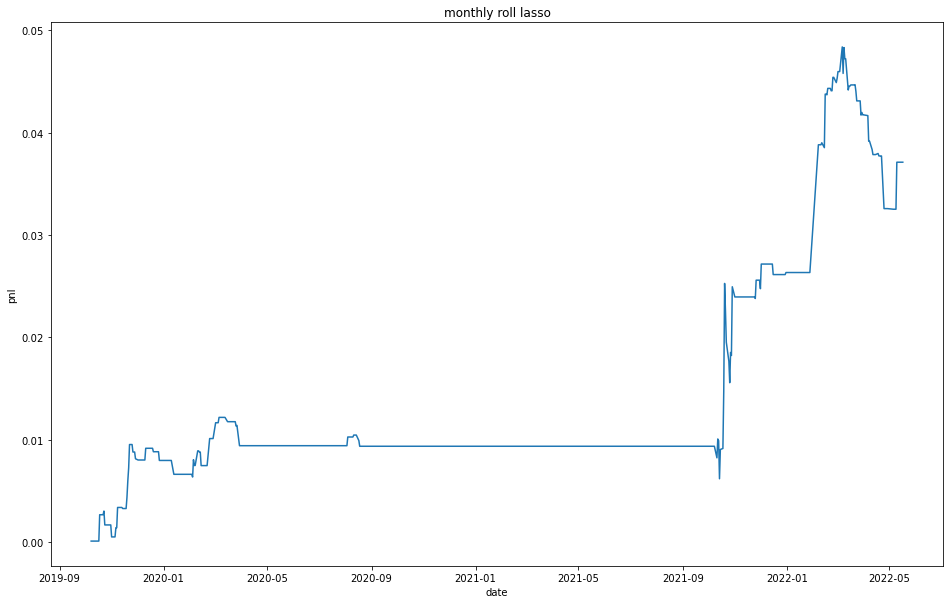

In [78]:
n_product = len(product_list)
save_path = "signal result atr"
strat = "roll.energy.lasso.4096"
start_month = 0
min_pnl = 2
min_num = 20
end_month = sum(month_len[0] < "201910")-1
all_pnl = np.array([])

for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        #print(product, len(train_pnl))
        #continue
        if i_product==0:
            train_mat = np.zeros((len(train_pnl), n_product))
            test_mat = np.zeros((len(test_pnl), n_product))
            n_train = len(train_pnl)
            n_test = len(test_pnl)
        train_mat[:,i_product] = train_pnl[-n_train:]
        test_mat[:,i_product] = test_pnl[-n_test:]
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    avg_test_pnl = test_mat.mean(axis=1)
    #avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #print(len(avg_test_pnl_mean)==len(avg_test_pnl))
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    #print(all_pnl)
    #print(len(all_pnl), len(avg_test_pnl))
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[-len(all_pnl):], all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

## sharpe  0.9649957999280745


sharpe  -1.9093421676657454


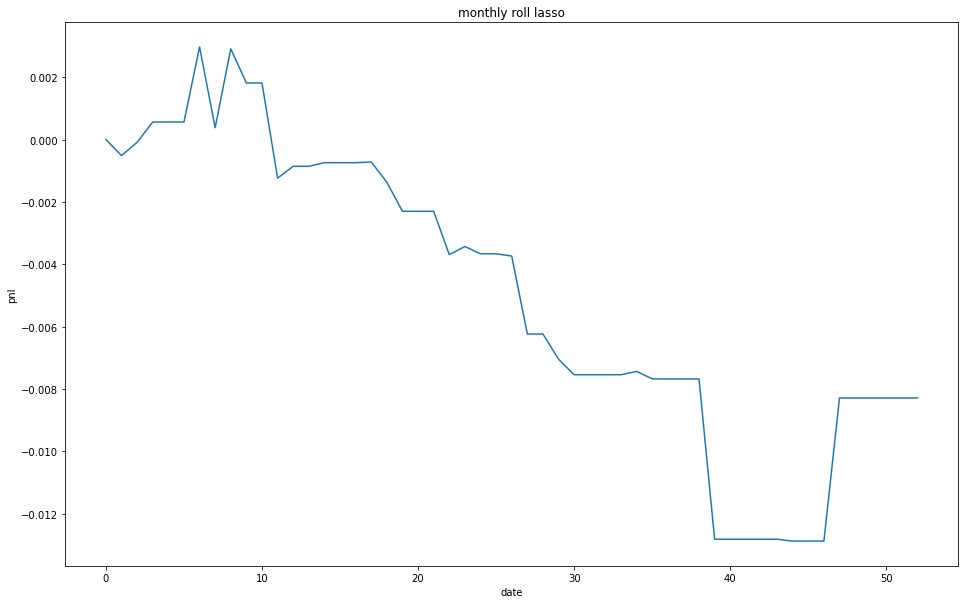

In [79]:
out_sample = all_dates>="20220225"
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
print("sharpe ", sharpe(all_pnl[-sum(out_sample):]))
plt.plot(all_pnl[-sum(out_sample):].cumsum());

## sharpe  -1.9093421676657454

- we can see that the result is not so good

- Congratulations! You have finished this course!
- Thank you very much for your participation! I wish you would enjoy taking this course!
- Happy trading in the future!